In [106]:
import numpy as np
import pandas as pd
import torch
import torchvision
import glob
import os
import matplotlib

from PIL import Image
from dataset.dataset import CrackDataset, DatasetType
from dotenv import load_dotenv
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from importlib import reload
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.utils import compute_sample_weight
import matplotlib.pyplot as plt

from models.heuristic import baseline_trans, train_trans, baseline_detect_crack, enhanced_detect_crack

In [4]:
load_dotenv(override=True)

True

# EDA

In [5]:
dataset = CrackDataset(os.environ["DATA_FOLDER"], DatasetType.TRAIN, transform=None)

## Examples

In [8]:
anomaly_ind = 69
normal_ind = 0
false_anomaly_ind = 35

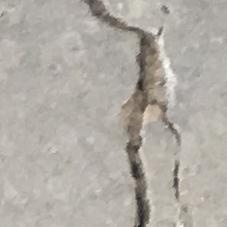

In [17]:
to_pil_image(dataset[anomaly_ind][0])

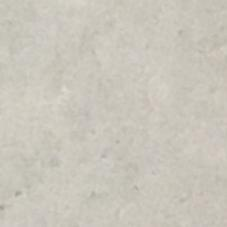

In [18]:
to_pil_image(dataset[normal_ind][0])

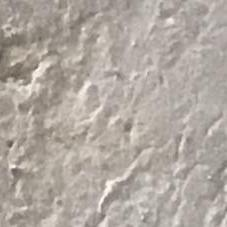

In [19]:
to_pil_image(dataset[false_anomaly_ind][0])

## Baseline preprocessing

In [43]:
dataset.transform = baseline_trans


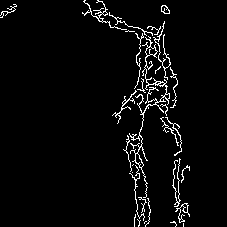

In [25]:
to_pil_image(dataset[anomaly_ind][0])

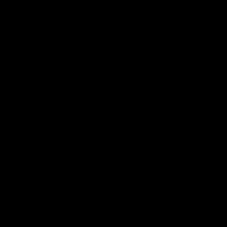

In [27]:
to_pil_image(dataset[normal_ind][0])

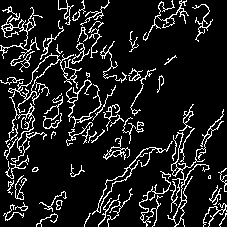

In [44]:
to_pil_image(dataset[false_anomaly_ind][0])

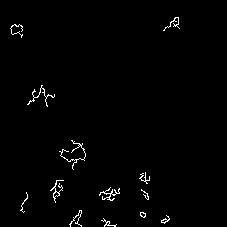

In [46]:
to_pil_image(dataset[59][0])

## Enhanced processing

In [47]:
dataset.transform = train_trans


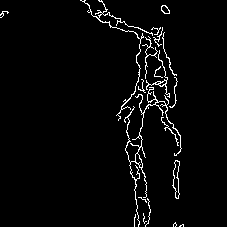

In [32]:
to_pil_image(dataset[anomaly_ind][0])

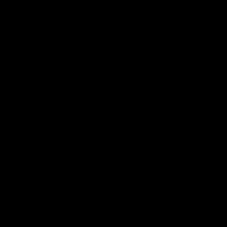

In [33]:
to_pil_image(dataset[normal_ind][0])

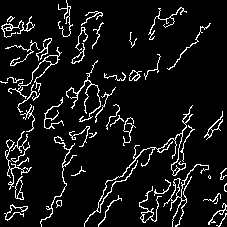

In [48]:
to_pil_image(dataset[false_anomaly_ind][0])

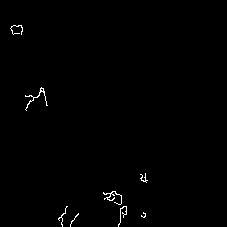

In [49]:
to_pil_image(dataset[59][0])

# Auto annotation

## Baseline

In [65]:
y_pred = []

for p in dataset.data:
    y_pred.append(
        baseline_detect_crack(p, 0.01)
    )

In [52]:
pd.DataFrame(y_pred[:70])

,0,1
0,0,0.000000
1,0,0.007840
2,0,0.000446
3,0,0.004502
4,0,0.000000
...,...,...
65,0,0.000000
66,0,0.002581
67,0,0.000524
68,0,0.000000


In [66]:
print('Anomalies detected in train out of 1: ', sum(map(lambda x: x[0], y_pred[:70])))

Anomalies detected in train out of 1:  11


In [67]:
print('Total anomalies detected in train: ', sum(map(lambda x: x[0], y_pred)))

Total anomalies detected in train:  3328


## Enhanced

In [68]:
y_pred = []

for p in dataset.data:
    y_pred.append(
        enhanced_detect_crack(p, 0.01)
    )

In [61]:
pd.DataFrame(y_pred[:70])

,0,1
0,0,0.000000
1,0,0.000000
2,0,0.000000
3,0,0.001145
4,0,0.000000
...,...,...
65,0,0.000000
66,0,0.001029
67,0,0.000000
68,0,0.000000


In [63]:
print('Anomalies detected in train out of 1: ', sum(map(lambda x: x[0], y_pred[:70])))

Anomalies detected in train out of 1:  2


In [64]:
print('Total anomalies detected in train: ', sum(map(lambda x: x[0], y_pred)))

Total anomalies detected in train:  706


## Save dataset

In [70]:
train_df = pd.DataFrame(y_pred, columns=['anomaly', 'probability'])
train_df.reset_index(inplace=True)
train_df.rename(columns={'index': 'name'}, inplace=True)
train_df

,name,anomaly,probability
0,0,0,0.000000
1,1,0,0.000000
2,2,0,0.000000
3,3,0,0.001145
4,4,0,0.000000
...,...,...,...
14995,14995,0,0.000834
14996,14996,0,0.000000
14997,14997,0,0.002523
14998,14998,0,0.000000


In [71]:
train_df.to_csv(os.path.join(os.environ['DATA_FOLDER'], 'train_enh_auto_labeled_thr0.01.csv'))

# Test quality

## Balanced test

In [119]:
val_ds = CrackDataset(os.environ["DATA_FOLDER"], DatasetType.EVAL_BALANCED, transform=None)

### Baseline annotations

In [120]:
y_pred = []
y_probas = []

for p in val_ds.data:
    pred = baseline_detect_crack(p, 0.01)

    y_pred.append(
        pred[0]
    )
    y_probas.append(pred[1])


In [121]:
pd.DataFrame(confusion_matrix(val_ds.labels, y_pred, )).style.background_gradient(axis='columns')

,0,1
0,827,173
1,5,995


In [122]:
f1_score(val_ds.labels, y_pred)

0.9178966789667896

In [123]:
roc_c = roc_curve(val_ds.labels, y_probas, pos_label=1, drop_intermediate=False)
roc_auc = auc(x=roc_c[0], y=roc_c[1])

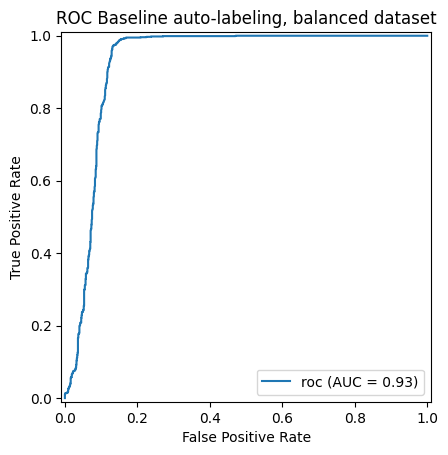

In [124]:
display = RocCurveDisplay(fpr=roc_c[0], tpr=roc_c[1], roc_auc=roc_auc, estimator_name='roc')
display.plot()
plt.title('ROC Baseline auto-labeling, balanced dataset')
plt.show()

### Enhanced

In [125]:
y_pred = []
y_probas = []

for p in val_ds.data:
    pred = enhanced_detect_crack(p, 0.01)

    y_pred.append(
        pred[0]
    )
    y_probas.append(pred[1])


In [126]:
pd.DataFrame(confusion_matrix(val_ds.labels, y_pred, )).style.background_gradient(axis='columns')

,0,1
0,983,17
1,59,941


In [127]:
f1_score(val_ds.labels, y_pred)

0.9611848825331971

In [128]:
roc_c = roc_curve(val_ds.labels, y_probas, pos_label=1, drop_intermediate=False)
roc_auc = auc(x=roc_c[0], y=roc_c[1])

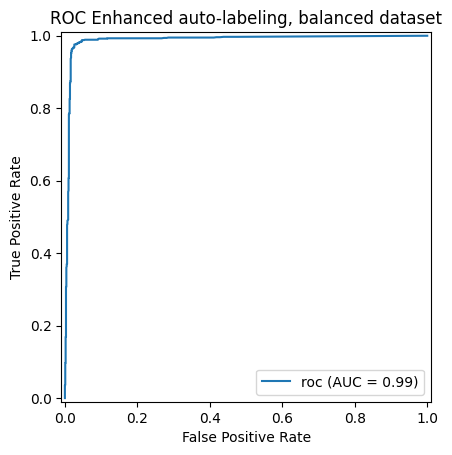

In [129]:
display = RocCurveDisplay(fpr=roc_c[0], tpr=roc_c[1], roc_auc=roc_auc, estimator_name='roc')
display.plot()
plt.title('ROC Enhanced auto-labeling, balanced dataset')
plt.show()

## Unbalanced

In [130]:
test_ds = CrackDataset(os.environ["DATA_FOLDER"], DatasetType.EVAL_UNBALANCED, transform=None)

### Baseline annotations

In [131]:
y_pred = []
y_probas = []

for p in test_ds.data:
    pred = baseline_detect_crack(p, 0.01)

    y_pred.append(
        pred[0]
    )
    y_probas.append(pred[1])


In [132]:
pd.DataFrame(confusion_matrix(test_ds.labels, y_pred, ),).style.background_gradient(axis='columns')

,0,1
0,802,168
1,0,30


In [133]:
print('F1 average: ', f1_score(test_ds.labels, y_pred))
print('F1 weighted: ', f1_score(test_ds.labels, y_pred, average='weighted'))

F1 average:  0.2631578947368421
F1 weighted:  0.8859308542235952


In [134]:
roc_c = roc_curve(test_ds.labels, y_probas, pos_label=1, drop_intermediate=False)
roc_auc = auc(x=roc_c[0], y=roc_c[1])

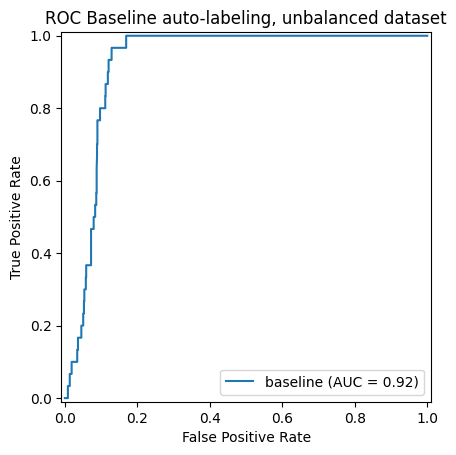

In [136]:
display = RocCurveDisplay(fpr=roc_c[0], tpr=roc_c[1], roc_auc=roc_auc, estimator_name='baseline')
display.plot()
plt.title('ROC Baseline auto-labeling, unbalanced dataset')
plt.show()

### Enhanced

In [139]:
y_pred = []
y_probas = []

for p in test_ds.data:
    pred = enhanced_detect_crack(p, 0.01)

    y_pred.append(
        pred[0]
    )
    y_probas.append(pred[1])


In [140]:
pd.DataFrame(confusion_matrix(test_ds.labels, y_pred, )).style.background_gradient(axis='columns')

,0,1
0,954,16
1,1,29


In [141]:
print('F1 average: ', f1_score(test_ds.labels, y_pred))
print('F1 weighted: ', f1_score(test_ds.labels, y_pred, average='weighted'))

F1 average:  0.7733333333333333
F1 weighted:  0.9846337662337662


In [142]:
roc_c = roc_curve(test_ds.labels, y_probas, pos_label=1, drop_intermediate=False)
roc_auc = auc(x=roc_c[0], y=roc_c[1])

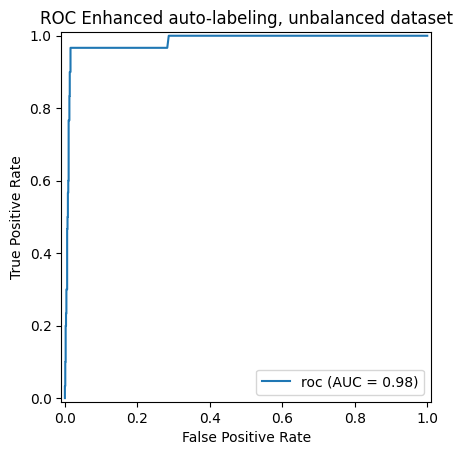

In [143]:
display = RocCurveDisplay(fpr=roc_c[0], tpr=roc_c[1], roc_auc=roc_auc, estimator_name='roc')
display.plot()
plt.title('ROC Enhanced auto-labeling, unbalanced dataset')
plt.show()